[find_floating_potential()]: ../../../api/plasmapy.analysis.swept_langmuir.floating_potential.find_floating_potential.rst#find-floating-potential

# Swept Langmuir Analysis: Floating Potential

This notebook covers the use of the [find_floating_potential()] function and how it is used to determine the floating potential from a swept Langmuir trace.

The floating potential, $V_f$, is defined as the probe bias voltage at which there is no net collected current, $I=0$.  This occurs because the floating potential slows the collected electrons and accelerates the collected ions to a point where the electron- and ion-currents balance each other out.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pprint

from pathlib import Path

from plasmapy.analysis import swept_langmuir as sla


np.set_printoptions(precision=4, threshold=16)

## Contents:

1. [How find_floating_potential() works](#How-find_floating_potential()-works)
    1. [Notes about usage](#Notes-about-usage)
    1. [Knobs to turn](#Knobs-to-turn)
1. [Calculate the Floating Potential](#Calculate-the-Floating-Potential)
    1. [Interpreting results](#Interpreting-results)
    1. [Plotting results](#Plotting-results)

## How `find_floating_potential()` works

1. The passed current array is scanned for points that equal zero and point-pairs that straddle where the current, $I$, equals zero.  This forms an collection of "crossing-points."
1. The crossing-points are then grouped into "crossing-islands" based on the `threshold` keyword.
    - A new island is formed when a successive crossing-point is more (index) steps away from the previous crossing-point than defined by `threshold`.  For example, if `threshold=4` then a new island is formed if a crossing-point candidate is more than 4 steps away from the previous candidate.
    - If multiple crossing-islands are identified, then the function will compare the total span of all crossing-islands to `min_points`.  If the span is greater than `min_points`, then the function is incapable of identifying $V_f$ and will return `numpy.nan` values; otherwise, the span will form one larger crossing-island.
1. To calculate the floating potential...
    - If the number of points that make up the crossing-island is less than `min_points`, then each side of the "crossing-island" is equally padded with the nearest neighbor points until `min_points` is satisfied.
    - If `fit_type="linear"`, then a `scipy.stats.linregress` fit is applied to the points that make up the crossing-island.
    - If `fit_type="exponential"`, then a `scipy.optimize.curve_fit` fit is applied to the points that make up the crossing-island.

### Notes about usage

- The function provides no signal processing.  If needed, the user must smooth, sort, crop, or process the arrays before passing them to the function.
- The function requires the voltage array to be monotonically increasing.
- If the total range spanned by all crossing-islands is less than or equal to `min_points`, then `threshold` is ignored and all crossing-islands are grouped into one island.

### Knobs to turn

- `fit_type`

    There are two types of curves that can be fitted to the identified crossing point data: `"linear"` and `"exponential"`.  The former will fit a line to the data, whereas, the latter will fit an exponential curve with an offset.  The default curve is `"exponential"` since swept Langmuir data is not typically linear as it passes through $I=0$.

- `min_points`

    This variable specifies the minimum number of points that will be used in the curve fitting.  As mentioned above, the crossing-islands are identified and then padded until `min_points` is satisfied.  Usage:
    
    - `min_points = None` (DEFAULT):  `min_points` is chosen to be the larger of 5 or `factor * array_size`, where `factor = 0.1` for `"linear"` and `0.2` for `"exponential"`.
    - `min_points = numpy.inf`:  The entire array is fitted.
    - `min_points` is an integer `>= 1`:  `min_points` is the minimum number of points to be used.
    - `0 < min_points < 1`:  The minimum number of points is taken as `min_points * array_size`.

- `threshold`

    The max allowed index distance between crossing-points before a new crossing-island is formed.

## Calculate the Floating Potential

Below we'll compute the floating potential using the default fitting behavior (`fit_type="exponential"`) and a linear fit (`fit_type="linear"`).

In [4]:
# load data
#filename = "Beckers2017_noisy.npy"
#filepath = (Path.cwd() / ".." / ".." / "langmuir_samples" / filename).resolve()
#voltage, current = np.load(filepath)

data = np.loadtxt('data/Kennlinie_Anode_GND/71_6.txt', skiprows=3)
offset = 300
offset2 = 600
voltage = data[offset:-offset2,0]
current = data[offset:-offset2, 1]

# voltage array needs to be monotonically increasing/decreasing
isort = np.argsort(voltage)
voltage = voltage[isort]
current = current[isort]

# get default fit results (exponential fit)
results = sla.find_floating_potential(voltage, current, min_points=0.3)

# get linear fit results
results_lin = sla.find_floating_potential(voltage, current, fit_type="linear")

[find_floating_potential()]: ../../../api/plasmapy.analysis.swept_langmuir.floating_potential.find_floating_potential.rst#find-floating-potential
[VFExtras]: ../../../api/plasmapy.analysis.swept_langmuir.floating_potential.VFExtras.rst#vfextras

### Interpreting results

The [find_floating_potential()] function returns a 2 element tuple, where the first element is the calculated floating potential $V_f$ and the second element is a named tuple [VFExtras] containing additional parameters resulting from the calculation.

- `results[0]` is the determined floating potential (same units as the pass `voltage` array)

In [6]:
vf = results[0]
vf

-6.398019621637211

[VFExtras]: ../../../api/plasmapy.analysis.swept_langmuir.floating_potential.VFExtras.rst#vfextras

- `results[1]` is an instance of [VFExtras] and contains additional information from the calculation

In [7]:
extras = results[1]
extras

VFExtras(vf_err=0.09119728870136795, rsq=0.9922744557494921, fitted_func=f(x) = a exp(alpha x) + b <class 'plasmapy.analysis.fit_functions.ExponentialPlusOffset'>, islands=[slice(430, 433, None), slice(462, 465, None), slice(467, 470, None), slice(488, 490, None), slice(493, 495, None), slice(500, 504, None), slice(510, 513, None), slice(518, 521, None)], fitted_indices=slice(310, 641, None))

- `extras[0]` = `extras.vf_err` = the associated uncertainty in the $V_f$ calculation (same units as `vf`)

In [8]:
(extras[0], extras.vf_err)

(0.09119728870136795, 0.09119728870136795)

- `extras[1]` = `extras.rsq` = the coefficient of determination (r-squared) value of the fit

In [9]:
(extras[1], extras.rsq)

(0.9922744557494921, 0.9922744557494921)

[FitFunction]: ../../../api_static/plasmapy.analysis.fit_functions.rst

- `extras[2]` = `extras.fitted_func` = the resulting fitted function

    - `extras.fitted_func` is a callable representation of the fitted function `I = extras.fitted_func(V)`.
    - `extras.fitted_func` is an instance of a sub-class of `AbstractFitFunction`. ([FitFunction classes][FitFunction])
    - Since `extras.fitted_func` is a class instance, there are many other attributes available.  For example,
        - `extras.fitted_func.params` is a named tuple of the fitted parameters
        - `extras.fitted_func.param_errors` is a named tuple of the fitted parameter errors
        - `extras.fitted_func.root_solve()` finds the roots of the fitted function. This is how $V_f$ is calculated.

In [10]:
(
    extras[2],
    extras.fitted_func,
    extras.fitted_func.params,
    extras.fitted_func.params.a,
    extras.fitted_func.param_errors,
    extras.fitted_func.param_errors.a,
    extras.fitted_func(vf),
)

(f(x) = a exp(alpha x) + b <class 'plasmapy.analysis.fit_functions.ExponentialPlusOffset'>,
 f(x) = a exp(alpha x) + b <class 'plasmapy.analysis.fit_functions.ExponentialPlusOffset'>,
 FitParamTuple(a=17.60051190662734, alpha=2.7766856276098832, b=-3.3896765695120126e-07),
 17.60051190662734,
 FitParamTuple(a=2.8927564923040583, alpha=0.029795842812615915, b=9.399973138148607e-09),
 2.8927564923040583,
 5.823351512373315e-22)

- `extras[3]` = `extras.islands` = a list of slice objects representing all the identified crossing-islands

In [ ]:
(
    extras[3],
    extras.islands,
    voltage[extras.islands[0]],
)

- `extras[4]` = `extras.fitted_indices` = a slice object representing the indices used in the fit

In [ ]:
(
    extras[4],
    extras.fitted_indices,
    voltage[extras.fitted_indices],
)

### Plotting results

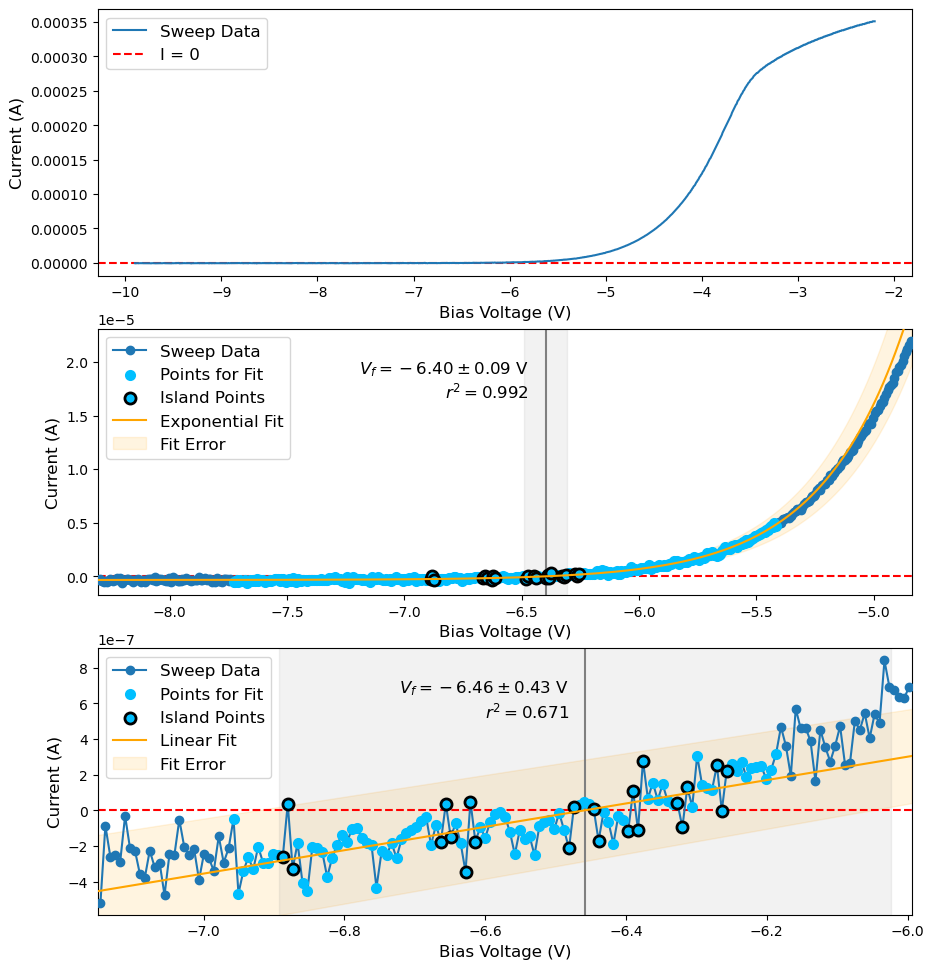